# Example usage of the Hybrid Model

In [1]:
# imports
import jax
import jax_cfd.base.equations as eqtns
import jax_cfd.base as cfd
import jax.numpy as jnp
import numpy as np
import xarray
import seaborn

In [2]:
## forcings

## Here are different types of forcing functions/conditions

# Linear force due to uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

# Turbulent forcing (kolmogorov forcing)
def turbulentForcing(grid):
    return cfd.forcings.simple_turbulence_forcing(grid, constant_magnitude = 0.5, linear_coefficient = -0.8) # params specified in jax-cfd for 2D turbulence

In [9]:
# intialising problem

#grid
#bcs
#initial velocities
#forcing

size = (256,64)
domain = ((0, 8), (0, 2))

density = 1. ### original 1.
viscosity = 1e-4 # kinematic viscosity ### original 1e-3

pressure_gradient = 2e-3  # uniform dP/dx ### original 2e-3


grid = cfd.grids.Grid(size, domain = domain)


velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

pressure_solve = cfd.pressure.solve_fast_diag_channel_flow ### solve_fast_diag_channel_flow OR solve_cg

vx_fn = lambda x, y: jnp.zeros_like(x) +1
vy_fn = lambda x, y: jnp.zeros_like(x)

max_velocity = 1.
cfl_safety_factor = 0.5

# time steps per output
# inner_steps = 1  ## defined below

# number of outputs
# outer_steps = 1000   ## defined below to allow the toTime method to work

forcing = lambda pressure_gradient, grid :  cfd.forcings.sum_forcings(
        pressure_gradient_forcing(pressure_gradient),
        #turbulentForcing(grid),
        cfd.forcings.taylor_green_forcing(grid, scale = 0.05)
        #cfd.forcings.kolmogorov_forcing(grid)
        #cfd.forcings.linear_forcing(grid,1.01)
        #cfd.forcings.filtered_forcing(grid = grid, spectral_density = 1)
        #cfd.forcings.filtered_linear_forcing(grid=grid, upper_wavenumber = 2, coefficient = 1, lower_wavenumber = 1)
)

#######################
# # Evaluate forcing and grid
# for i in range(len(simSpecs)):
#     simSpecs[i]['grid'] = grid = cfd.grids.Grid(simSpecs[i]["size"], 
#                                                               domain=simSpecs[i]["domain"])
#     simSpecs[i]['forcing'] = simSpecs[i]['forcing'](pressure_gradient = simSpecs[i]['pressure_gradient'], 
#                                          grid = simSpecs[i]['grid']
#       )
#######################


forcing = forcing(pressure_gradient = pressure_gradient, 
                  grid = grid)

In [59]:
# finish setting up simulation
v0 = cfd.initial_conditions.initial_velocity_field(
       velocity_fns = (vx_fn, vy_fn),
       grid = grid,
       velocity_bc = velocity_bc,
       pressure_solve = pressure_solve,
       iterations=5)




## divergence check
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

# calculate stable timestep (do we need to save this?)
dt = cfd.equations.stable_time_step(max_velocity, 
                                    cfl_safety_factor, 
                                    viscosity, 
                                    grid)


## define convection function
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)


# time steps per output
inner_steps = 1

# Option ONE
outer_steps = 10

# Option TWO
toTime = False
if toTime:
    target_sim_time = 15 #in time
    outer_steps = target_sim_time//(inner_steps*dt)
    


## Defining and choosing a number of different numerical step functions

In [60]:
# define function to advance one timestep

# Semi-implicit Navier Stokes
NS_step_functions = {
    
    "semi_implicit_navier_stokes" : cfd.equations.semi_implicit_navier_stokes(
                                        density=density,
                                        viscosity=viscosity,
                                        dt=dt,
                                        grid=grid,
                                        convect=convect,
                                        pressure_solve = pressure_solve,
                                        forcing= forcing
                                        ),
                                        
        
}


NS_step = NS_step_functions["semi_implicit_navier_stokes"]

In [61]:
# composing (joining) two functions (output of one is input of the other)
def compose(second_fun, first_fun):
        return lambda x : second_fun(first_fun(x))
    

In [62]:
def corrector(v):
    for i in range(len(v)):
        v[i].array.data += 0
    return v

In [63]:
#building the single step block
single_step = cfd.funcutils.repeated(compose(NS_step,corrector),
                       steps=inner_steps)

In [64]:
print(v0)
print(corrector(v0))

(GridVariable(array=GridArray(data=DeviceArray([[1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             ...,
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.]], dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(256, 64), step=(0.03125, 0.03125), domain=((0.0, 8.0), (0.0, 2.0)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('dirichlet', 'dirichlet')), bc_values=((0.0, 0.0), (0.0, 0.0)))), GridVariable(array=GridArray(data=DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), offset=(0.5, 1.0), grid=Grid(shape=(256, 64), step=(0.03125, 0.03125), domain=((0.0, 8.0), (0.

## Defining the ML section of the solver


In [ ]:
# Add corrector/inference network

In [73]:
# jax.jit function enables execution on CPU/GPU/TPU
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    single_step, outer_steps, start_with_input=True))

In [74]:
## compute trajectory
%time _, trajectory = jax.device_get(rollout_fn(v0))

    
# return jax.device_get(rollout_fn(v0)),dt,outer_steps

CPU times: user 1.54 s, sys: 91.8 ms, total: 1.63 s
Wall time: 1.52 s


In [71]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

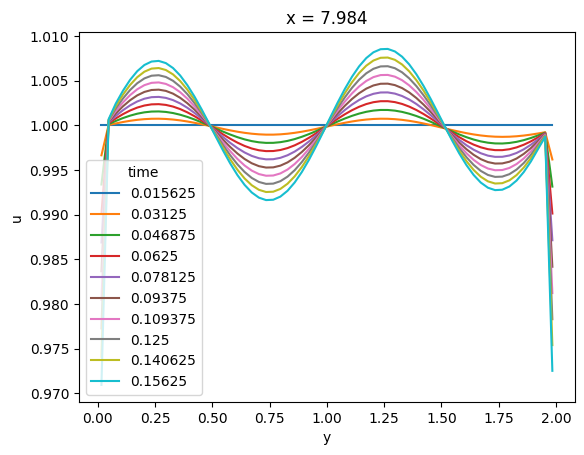

In [72]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')

In [ ]:
# define way to get time derivative loss

In [13]:
# define way to get integrated solution loss